In [1]:
include("../ToolBox/ToolBox.jl")
using .ToolBox
using .UnitTest
using .Geometry
using .Load
using .Misc
using Plots
using Statistics
using Polynomials

proj_create: init=epsg:/init=IGNF: syntax not supported in non-PROJ4 emulation mode


## Noter
- Der er noget med fortegnet på vores statevectors og dem fra Johns kode
- Hvor for gamma 15 state vectors fra? Vi vælger 49 ud fra POE
- hvor kommer "time_state_vectors" in i billedet i Johns kode
    - Når der er styr på det er det muligt at sammenligne polyfit og polyval på de 15 vektorer
    - sammenlign de to metoders fejl på polyval af den manglende vektore. 

- hvis du får lavet en oversættelse mellem vores og gamma state vectors så kør unit test med gamma SV igen.
- plottet viser at der er noget der er rigtigt, men skal de lige lægges det rigtige tidspunkt. du kan bruge gamma starttid for første sv: 20342.0000 s og intervallet mellem sv's = 10 s

#### Hard-coded state-vectors from gamma .par

In [2]:
state_vector_position_1 = [3517345.9262,    1192277.2110,    6013022.4307] 
state_vector_velocity_1 = [  6568.41746,      -207.88353,     -3792.11336] 
state_vector_position_2 = [3582830.3513,    1190083.8479,    5974762.8150] 
state_vector_velocity_2 = [  6528.33957,      -230.77535,     -3859.73816] 
state_vector_position_3 = [3647910.1657,    1187661.9861,    5935829.1124] 
state_vector_velocity_3 = [  6487.49607,      -253.58267,     -3926.92946] 
state_vector_position_4 = [3712577.7365,    1185012.4887,    5896225.6959] 
state_vector_velocity_4 = [  6445.89162,      -276.30184,     -3993.67967] 
state_vector_position_5 = [3776825.4776,    1182136.2556,    5855957.0142] 
state_vector_velocity_5 = [  6403.53094,      -298.92921,     -4059.98125] 
state_vector_position_6 = [3840645.8508,    1179034.2230,    5815027.5910] 
state_vector_velocity_6 = [  6360.41887,      -321.46114,     -4125.82670] 
state_vector_position_7 = [3904031.3668,    1175707.3634,    5773442.0251] 
state_vector_velocity_7 = [  6316.56033,      -343.89401,     -4191.20858] 
state_vector_position_8 = [3966974.5859,    1172156.6854,    5731204.9893] 
state_vector_velocity_8 = [  6271.96032,      -366.22423,     -4256.11948] 
state_vector_position_9 = [4029468.1188,    1168383.2333,    5688321.2299] 
state_vector_velocity_9 = [  6226.62394,      -388.44822,     -4320.55207] 
state_vector_position_10 = [4091504.6276,    1164388.0873,    5644795.5666]
state_vector_velocity_10 = [  6180.55637,      -410.56242,     -4384.49904]
state_vector_position_11 = [4153076.8268,    1160172.3631,    5600632.8917]
state_vector_velocity_11 = [  6133.76289,      -432.56328,     -4447.95315]
state_vector_position_12 = [4214177.4839,    1155737.2116,    5555838.1700]
state_vector_velocity_12 = [  6086.24886,      -454.44728,     -4510.90721]
state_vector_position_13 = [4274799.4204,    1151083.8190,    5510416.4376]
state_vector_velocity_13 = [  6038.01972,      -476.21093,     -4573.35409]
state_vector_position_14 = [4334935.5130,    1146213.4062,    5464372.8021]
state_vector_velocity_14 = [  5989.08103,      -497.85074,     -4635.28668]
state_vector_position_15 = [4394578.6942,    1141127.2288,    5417712.4415]
state_vector_velocity_15 = [  5939.43838,      -519.36326,     -4696.69797];

In [3]:
state_vector_position = vcat(transpose(state_vector_position_1), transpose(state_vector_position_2),
        transpose(state_vector_position_3), transpose(state_vector_position_4),
        transpose(state_vector_position_5), transpose(state_vector_position_6),
        transpose(state_vector_position_7), transpose(state_vector_position_8),
        transpose(state_vector_position_9), transpose(state_vector_position_10),
        transpose(state_vector_position_11), transpose(state_vector_position_12),
        transpose(state_vector_position_13), transpose(state_vector_position_14), 
        transpose(state_vector_position_15));

In [4]:
state_vector_velocity = vcat(transpose(state_vector_velocity_1), transpose(state_vector_velocity_2),
        transpose(state_vector_velocity_3), transpose(state_vector_velocity_4),
        transpose(state_vector_velocity_5), transpose(state_vector_velocity_6),
        transpose(state_vector_velocity_7), transpose(state_vector_velocity_8),
        transpose(state_vector_velocity_9), transpose(state_vector_velocity_10),
        transpose(state_vector_velocity_11), transpose(state_vector_velocity_12),
        transpose(state_vector_velocity_13), transpose(state_vector_velocity_14), 
        transpose(state_vector_velocity_15));

In [5]:
state_vector_gamma = hcat(state_vector_position, state_vector_velocity);

In [6]:
## LOADING
master_safe_path = "/Users/eyu/local_data/data/phase_bug/BB/S1B_IW_SLC__1SDV_20170408T053951_20170408T054019_005065_008DBC_AEEF.SAFE"
m_data_path, m_meta_path, m_calibration_path = Load.slc_paths(master_safe_path, "VV", 3);
m_meta = Load.slc_meta(m_meta_path);
m_pod = Load.precise_orbit(Load.pod_path(m_meta["t_0"], m_meta["mission_id"],
                        "/Users/eyu/local_data/data/phase_bug/POD"), m_meta["t_0"])
m_start_time, m_stop_time = UnitTest.meta_start_datetime(m_meta_path)

("2017-04-08T05:39:51.390773", "2017-04-08T05:40:19.352505")

In [125]:
time_gamma = (20342 - UnitTest.seconds_since_midnight(m_meta["t_0"])):10:(20342 - UnitTest.seconds_since_midnight(m_meta["t_0"]) + 10*14)

1.999999999989086:10.0:141.9999999999891

In [7]:
# coded like this for now,
# TODO: look into loading gamma .par and get these params out
c = 299792458
gamma_meta = Dict()
t_start = m_meta["t_start"] + 20394.149330 - UnitTest.seconds_since_midnight(m_start_time)
t_stop = m_meta["t_stop"] + 20402.797055 - UnitTest.seconds_since_midnight(m_stop_time)
state_vectors = m_pod[1]
time_state_vectors = m_pod[2]
poly_degree=4
max_time_margin=240.;

240.0

In [44]:
t_start, t_stop, t_mid

(54.15010299998903, 62.79755999998815, 58.47383149998859)

In [94]:
dt = t_stop - t_start;  # i Matlab=8.6477253540906531270593404769897
t_mid = t_start + dt / 2
t_step = time_gamma[2]-time_gamma[1]
max_time_margin = max(max_time_margin, (poly_degree + 2) / 2 * t_step)
# vælger 49 state vectors ud, !!! potentiel fejl: time_state_vectors er stadig rel til time of day.
gamma_nearby_state_vector_idx = abs.(time_gamma .- t_mid) .<= dt/2 + max_time_margin

# Check if enough point are selected
#if sum(nearby_state_vector_idx) < poly_degree + 1
#    println("Insufficient number of state vectors exiting.")
#    return
#end

# slice data to close times
gamma_nearby_state_vector_t_sv = time_gamma[gamma_nearby_state_vector_idx];
gamma_nearby_state_vector_state_vectors = state_vector_gamma[gamma_nearby_state_vector_idx, :];
time_10 = gamma_nearby_state_vector_t_sv[10];
vector_10 = gamma_nearby_state_vector_state_vectors[10, :];

In [95]:
gamma_nearby_state_vector_state_vectors = gamma_nearby_state_vector_state_vectors[1:end .!= 10, :]
gamma_nearby_state_vector_t_sv = gamma_nearby_state_vector_t_sv[1:end .!= 10];

In [96]:
state_vectors_poly, state_vectors_mean, state_vectors_std = Geometry.polyfit_state_vectors(gamma_nearby_state_vector_state_vectors, 
                                                                            gamma_nearby_state_vector_t_sv, 
                                                                            poly_degree=poly_degree, 
                                                                            do_scale=1);

In [97]:
poly_list = state_vectors_poly
y_mean = state_vectors_mean
y_std = state_vectors_std

#function polyval_state_vectors(poly_list,time,y_mean,y_std)
y_norm_fit = [Polynomials.polyval(poly_elem, time_10) for poly_elem in poly_list]

# re-normalize the fitted data
y_fit = y_norm_fit .* y_std .+ y_mean
#end
#function polyval_state_vectors(poly_list,time)
#end

6-element Array{Float64,1}:
     4.091504618865968e6
     1.164388089194282e6
     5.644795571480106e6
  6180.556374301196     
  -410.56241051416475   
 -4384.49903238004      

In [104]:
println(y_fit)
println(vector_10)

[4.0915e6, 1.16439e6, 5.6448e6, 6180.56, -410.562, -4384.5]
[4.0915e6, 1.16439e6, 5.6448e6, 6180.56, -410.562, -4384.5]


In [111]:
# errors in julia
sqrt(mean((y_fit[1:3] - vector_10[1:3]).^2)), sqrt(mean((y_fit[4:end] - vector_10[4:end]).^2))

(0.005878975167221586, 7.450841977478858e-6)

In [112]:
# errors in matlab
0.005905664485097370, 0.000007475707359516

(0.00590566448509737, 7.475707359516e-6)

In [113]:
gamma_xsat = [4091504.618826714344322681427002, 1164388.0891962570603936910629272, 5644795.5715055363252758979797363]
gamma_vsat = [6180.5563743279981281375512480736, -410.56241050029103689666953869164, -4384.4990323395450104726478457451];

In [117]:
sqrt(mean((y_fit[1:3] - gamma_xsat).^2)), sqrt(mean((y_fit[4:end] - gamma_vsat).^2))

(2.7027676810621955e-5, 2.91586877745659e-8)

In [114]:
println(y_fit[1:3])
println(gamma_xsat)

[4.0915e6, 1.16439e6, 5.6448e6]
[4.0915e6, 1.16439e6, 5.6448e6]


In [116]:
println(y_fit[4:end])
println(gamma_vsat)

[6180.56, -410.562, -4384.5]
[6180.56, -410.562, -4384.5]


In [10]:
dt = t_stop - t_start;  # i Matlab=8.6477253540906531270593404769897
t_mid = t_start + dt / 2
t_step = time_state_vectors[2]-time_state_vectors[1]
max_time_margin = max(max_time_margin, (poly_degree + 2) / 2 * t_step)

# vælger 49 state vectors ud, !!!
nearby_state_vector_idx = abs.(time_state_vectors .- t_mid) .<= dt/2 + max_time_margin

# Check if enough point are selected
if sum(nearby_state_vector_idx) < poly_degree + 1
    println("Insufficient number of state vectors exiting.")
    return
end

# slice data to close times
nearby_state_vector_t_sv = time_state_vectors[nearby_state_vector_idx];
nearby_state_vector_state_vectors = state_vectors[nearby_state_vector_idx,:];

state_vectors_poly, state_vectors_mean, state_vectors_std = Geometry.polyfit_state_vectors(nearby_state_vector_state_vectors, 
                                                                            nearby_state_vector_t_sv, 
                                                                            poly_degree=poly_degree, 
                                                                            do_scale=1);


┌ Warning: `polyfit(x, y, n=length(x) - 1, sym=:x)` is deprecated, use `fit(Poly, x, y, n; var=sym)` instead.
│   caller = polyfit(::Array{Float64,1}, ::Array{Float64,1}, ::Int64) at deprecated.jl:56
└ @ Polynomials ./deprecated.jl:56


In [124]:
findall(abs.(time_state_vectors .- t_mid) .<= dt/2 + max_time_margin)

49-element Array{Int64,1}:
 2379
 2380
 2381
 2382
 2383
 2384
 2385
 2386
 2387
 2388
 2389
 2390
 2391
    ⋮
 2416
 2417
 2418
 2419
 2420
 2421
 2422
 2423
 2424
 2425
 2426
 2427

In [35]:
#gamma_time = (20342 - UnitTest.seconds_since_midnight(m_start_time)):10:((20342 + 10*15) - UnitTest.seconds_since_midnight(m_stop_time))


-49.39000000001033:10.0:90.60999999998967

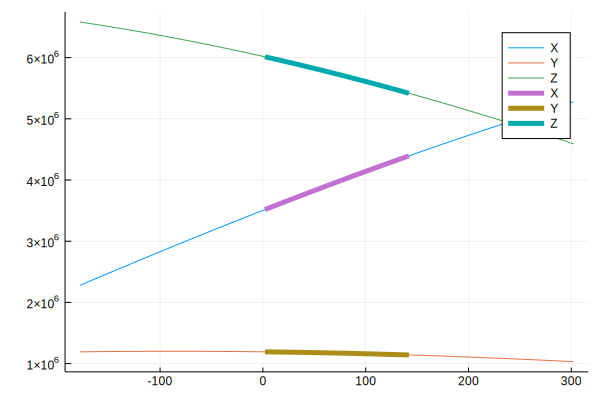

In [130]:
plot(nearby_state_vector_t_sv, nearby_state_vector_state_vectors[:, 1:3], label = ["X" "Y" "Z"])
plot!(time_gamma, state_vector_gamma[:, 1:3], linewidth=5, label = ["X" "Y" "Z"])

In [101]:
50 .+ time_gamma

0.6099999999896681:10.0:140.60999999998967

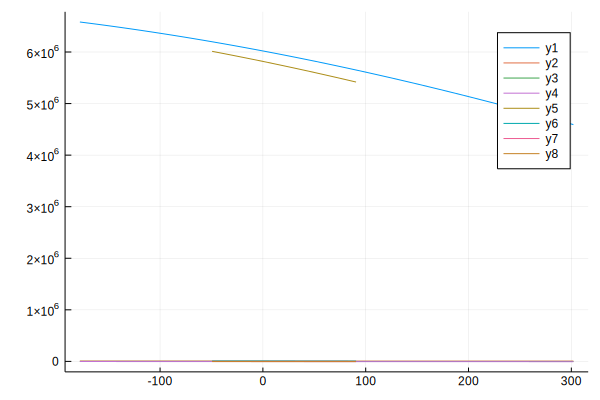

In [37]:
plot(nearby_state_vector_t_sv, nearby_state_vector_state_vectors[:, 3:end])
plot!(time_gamma, state_vector_gamma[:, 3:end])

In [21]:
nearby_state_vector_t_sv[1:20]

20-element Array{Float64,1}:
 -178.0
 -168.0
 -158.0
 -148.0
 -138.0
 -128.0
 -118.0
 -108.0
  -98.0
  -88.0
  -78.0
  -68.0
  -58.0
  -48.0
  -38.0
  -28.0
  -18.0
   -8.0
    2.0
   12.0

In [26]:
y = nearby_state_vector_state_vectors
time = nearby_state_vector_t_sv
poly_degree=4
do_scale=1

y_mean = mean(y,dims=1)
y_std = std(y,dims=1)
y_norm = (y.-y_mean)./y_std

1×6 Array{Float64,2}:
 8.97102e5  52272.1  5.9772e5  631.198  316.882  925.545

In [34]:
time

49-element Array{Float64,1}:
 -178.0
 -168.0
 -158.0
 -148.0
 -138.0
 -128.0
 -118.0
 -108.0
  -98.0
  -88.0
  -78.0
  -68.0
  -58.0
    ⋮  
  192.0
  202.0
  212.0
  222.0
  232.0
  242.0
  252.0
  262.0
  272.0
  282.0
  292.0
  302.0

In [32]:

Polynomials.polyfit(time, y_norm[:, 1], poly_degree)

Poly(-0.3965530106954035 + 0.007330634606562362*x - 2.2045595767170277e-6*x^2 - 1.4300860464064747e-9*x^3 + 2.3412362494786853e-13*x^4)

In [ ]:

y_norm = (y.-y_mean)./y_std
poly_list = [Polynomials.polyfit(time, y_norm[:,i],poly_degree) for i in 1:size(y)[2]]


In [23]:
nearby_state_vector_state_vectors

49×6 Array{Float64,2}:
 2.2784e6   1.19192e6  6.58191e6  7154.16   214.353   -2509.65
 2.34981e6  1.19395e6  6.55644e6  7128.55   190.583   -2583.73
 2.42096e6  1.19573e6  6.53023e6  7102.11   166.829   -2657.52
 2.49185e6  1.19728e6  6.50329e6  7074.84   143.095   -2731.02
 2.56246e6  1.1986e6   6.47561e6  7046.74   119.386   -2804.2 
 2.63278e6  1.19967e6  6.44721e6  7017.81    95.7037  -2877.08
 2.70281e6  1.20051e6  6.41807e6  6988.07    72.0537  -2949.63
 2.77254e6  1.20111e6  6.38821e6  6957.51    48.4392  -3021.84
 2.84196e6  1.20148e6  6.35764e6  6926.13    24.8641  -3093.72
 2.91106e6  1.20161e6  6.32634e6  6893.95     1.3323  -3165.26
 2.97984e6  1.20151e6  6.29433e6  6860.95   -22.1525  -3236.43
 3.04828e6  1.20117e6  6.26161e6  6827.15   -45.5864  -3307.25
 3.11638e6  1.2006e6   6.22819e6  6792.56   -68.9657  -3377.69
 ⋮                                                        ⋮   
 4.68516e6  1.11251e6  5.17535e6  5680.87  -624.897   -4995.69
 4.7417e6   1.10615e6  5.1251e6 

In [21]:
poly_list
dropdims(y_mean, dims=1);
dropdims(y_std, dims=1);

6-element Array{Polynomials.PolyCompat.Poly{Float64},1}:
 Polynomials.PolyCompat.Poly(-0.3965530106954035 + 0.007330634606562362*x - 2.2045595767170277e-6*x^2 - 1.4300860464064747e-9*x^3 + 2.3412362494786853e-13*x^4)
 Polynomials.PolyCompat.Poly(0.7509781197977988 - 0.003889146433654773*x - 2.1948476462889976e-5*x^2 + 2.54687789610015e-9*x^3 + 2.84952682119766e-12*x^4)     
 Polynomials.PolyCompat.Poly(0.5221114556963459 - 0.006321576509705655*x - 5.6812287118555765e-6*x^2 + 1.1815329531118397e-9*x^3 + 5.123645892898026e-13*x^4)  
 Polynomials.PolyCompat.Poly(0.5286125051891066 - 0.0062641865207856895*x - 6.1073952620078615e-6*x^2 + 1.1842977422630958e-9*x^3 + 5.88759834816067e-13*x^4)  
 Polynomials.PolyCompat.Poly(0.41146743083288556 - 0.007242071831392807*x + 1.2647621238281611e-6*x^2 + 1.93836708248814e-9*x^3 - 2.4142071361554797e-13*x^4)  
 Polynomials.PolyCompat.Poly(0.3951421124365749 - 0.007338802122207214*x + 2.293110029805801e-6*x^2 + 1.3788995825778919e-9*x^3 - 2.27014525012

In [19]:
nearby_state_vector_t_sv[1:20]

20-element Array{Float64,1}:
 -178.0
 -168.0
 -158.0
 -148.0
 -138.0
 -128.0
 -118.0
 -108.0
  -98.0
  -88.0
  -78.0
  -68.0
  -58.0
  -48.0
  -38.0
  -28.0
  -18.0
   -8.0
    2.0
   12.0

In [22]:
nearby_state_vector_state_vectors

49×6 Array{Float64,2}:
 2.2784e6   1.19192e6  6.58191e6  7154.16   214.353   -2509.65
 2.34981e6  1.19395e6  6.55644e6  7128.55   190.583   -2583.73
 2.42096e6  1.19573e6  6.53023e6  7102.11   166.829   -2657.52
 2.49185e6  1.19728e6  6.50329e6  7074.84   143.095   -2731.02
 2.56246e6  1.1986e6   6.47561e6  7046.74   119.386   -2804.2 
 2.63278e6  1.19967e6  6.44721e6  7017.81    95.7037  -2877.08
 2.70281e6  1.20051e6  6.41807e6  6988.07    72.0537  -2949.63
 2.77254e6  1.20111e6  6.38821e6  6957.51    48.4392  -3021.84
 2.84196e6  1.20148e6  6.35764e6  6926.13    24.8641  -3093.72
 2.91106e6  1.20161e6  6.32634e6  6893.95     1.3323  -3165.26
 2.97984e6  1.20151e6  6.29433e6  6860.95   -22.1525  -3236.43
 3.04828e6  1.20117e6  6.26161e6  6827.15   -45.5864  -3307.25
 3.11638e6  1.2006e6   6.22819e6  6792.56   -68.9657  -3377.69
 ⋮                                                        ⋮   
 4.68516e6  1.11251e6  5.17535e6  5680.87  -624.897   -4995.69
 4.7417e6   1.10615e6  5.1251e6 